In [1]:
# IMPORTS
import requests
import json
from sportmonks.soccer import SoccerApiV2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import xlsxwriter
import excel2json
from datetime import datetime
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# JSON FORMAT PRINT
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

In [3]:
# API key
soccer = SoccerApiV2(api_token='kDasthE00jpkFjEERAZNFyE9a79LNX3tPeaAqlhB3s2NhckJbKDhyL94j7AO')

In [4]:
# START AND END DATE 
start_date = "2018-08-10"
end_date = "2019-05-12"

# EMPTY LIST FOR ALL THE VARIABLES
lijst = []
sub_list = []
sub_list_min = []

# START QUERY
ids = soccer.fixtures(start_date, end_date, includes=('lineup', 'substitutions', 'venue'))

# CHANGE THIS LIST TO THE FEATURES YOU APPED
inhoud = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Age', 'Injured'] 
# inhoud = ['Position', 'Minutes_played', 'Day_since_start', 'Venue', 'Injured'] 
lijst.append(inhoud)

# FOR LOOP TO GET ALL THE FIXTURES IN BETWEEN THE START AND END DATE
for f in ids:
    team = []
    index = 0
    
    # WHILE LOOP TO GET EVERY PLAYER OF THE LINEUP
    while len(team) < len(f['lineup']):
        speler = []
        minutes = 0
        
        # STANDARD FEATURES (name, position, minutes played, day since start date, injury)
        
        # NAME PLAYER
        name = f['lineup'][index]['player_name']
        speler.append(name)
        team.append(speler)   
    
        # POSITION PLAYER
        position = f['lineup'][index]['position']
        speler.append(position)
        
        # MINUTES PLAYED
        minutes = f['lineup'][index]['stats']['other']['minutes_played']
        if minutes == None:
            minutes = 0
        speler.append(minutes)
        
        # DAY SINCE START DATE
        current_date = f["time"]["starting_at"]["date"]
        date_format = "%Y-%m-%d"
        a = datetime.strptime(start_date, date_format)
        b = datetime.strptime(current_date, date_format)
        delta = b - a
        speler.append(delta.days)
        
        
        # VARIABLE FEATURES 
        
        # AGE
        current_date = f["time"]["starting_at"]["date"]   
        id_player = f['lineup'][index]['player_id']
        
        player = soccer.player(id_player)
        
        birth_date = player['birthdate']
        format_current = "%Y-%m-%d"
        format_birth = "%d/%m/%Y"
        a = datetime.strptime(birth_date, format_birth)
        b = datetime.strptime(current_date, format_current)
        delta = b - a
        years = int(delta.days / 365.25)
        speler.append(years)
        
        
        # TARGET VALUE IF THE PLAYER IS INJURED
        
        # INJURY
        injury_index = 0 
        injured = 'null'
        while injury_index < len(f['substitutions']):
            sub = []
            player_name = name.split(' ')
            sub_name = f['substitutions'][injury_index]['player_out_name']
            sub_name_split = sub_name.split(' ')  
            if player_name[-1] == sub_name_split[-1]:
                injured = f['substitutions'][injury_index]['injuried']
                break
            else:
                injury_index += 1
        if injured == True :
            speler.append('Yes')
        else:
            speler.append('No')
        
        # APPEND THE PLAYER TO THE BIG LIST
        lijst.append(speler)
        index += 1


print(lijst)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [42]:
# CODE TO EXPORT TO EXCEL 
with xlsxwriter.Workbook('ajaxage.xlsx') as workbook:
    worksheet = workbook.add_worksheet()

    for row_num, data in enumerate(lijst):
        worksheet.write_row(row_num, 0, data)

# CODE TO CONVERT EXCEL FILE TO JSON --> (Sheet1.json)
excel2json.convert_from_file('ajaxage.xlsx')


In [43]:
# READ THE JOSN FILE AND PRINT HEAD
ajax = pd.read_json("Sheet1.json")
print(ajax)

                  Name Position  Minutes_played  Day_since_start  Age Injured
0        Diederik Boer        G              90                0   37      No
1    Kingsley Ehizibue        D              90                0   23      No
2       Darryl Lachman        D              90                0   28      No
3       Dirk Marcellis        D              90                0   30      No
4       Bram Van Polen        D              90                0   32      No
..                 ...      ...             ...              ...  ...     ...
587         Matúš Bero        M              75               16   22      No
588      Navarone Foor        M              90               16   26      No
589        Roy Beerens        A              65               16   30      No
590         Tim Matavz        A              79               16   29      No
591      Bryan Linssen        A              90               16   27      No

[592 rows x 6 columns]


In [44]:
# inhoud = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Injuried', 'Venue'] 

le = preprocessing.LabelEncoder()

ajax['Name'] = le.fit_transform(ajax['Name'])
ajax['Position'] = le.fit_transform(ajax['Position'])
ajax['Injured'] = le.fit_transform(ajax['Injured'])

In [45]:
Y = ajax.Injured
X = ajax.drop('Injured', axis = 1)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [47]:
classifier = DecisionTreeClassifier(random_state=0, max_depth=None)
classifier.fit(X_train_val, y_train_val)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [48]:
# PREDICT VALIDATION
y_pred = classifier.predict(X_val)

In [49]:
# PRINT ACCURACY SCORE
print(accuracy_score(y_val, y_pred))

0.968421052631579


In [50]:
# # TRANSFORM LABELS BACK TO ORIGINAL ENCODING
# print(ajax['Injured'])
ajax['Injured'] = le.inverse_transform(ajax['Injured'])
# print(ajax['Injured'])

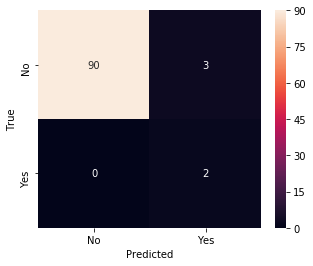

In [51]:
# PRINT CONFUSION MATRIX
features = ajax['Injured'].unique()
confusion = pd.DataFrame(confusion_matrix(y_val, y_pred),columns=features,index=features)
plt.figure(figsize=(5,4))
sns.heatmap(confusion,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [52]:
# PREDICT TEST 
y_pred = classifier.predict(X_test)

In [53]:
# PRINT ACCURACY SCORE
print(accuracy_score(y_test, y_pred))

0.957983193277311


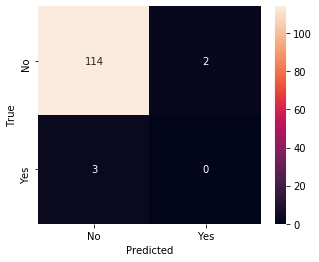

In [54]:
# PRINT CONFUSION MATRIX
features = ajax['Injured'].unique()
confusion=pd.DataFrame(confusion_matrix(y_test,y_pred),columns=features,index=features)
plt.figure(figsize=(5,4))
sns.heatmap(confusion,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

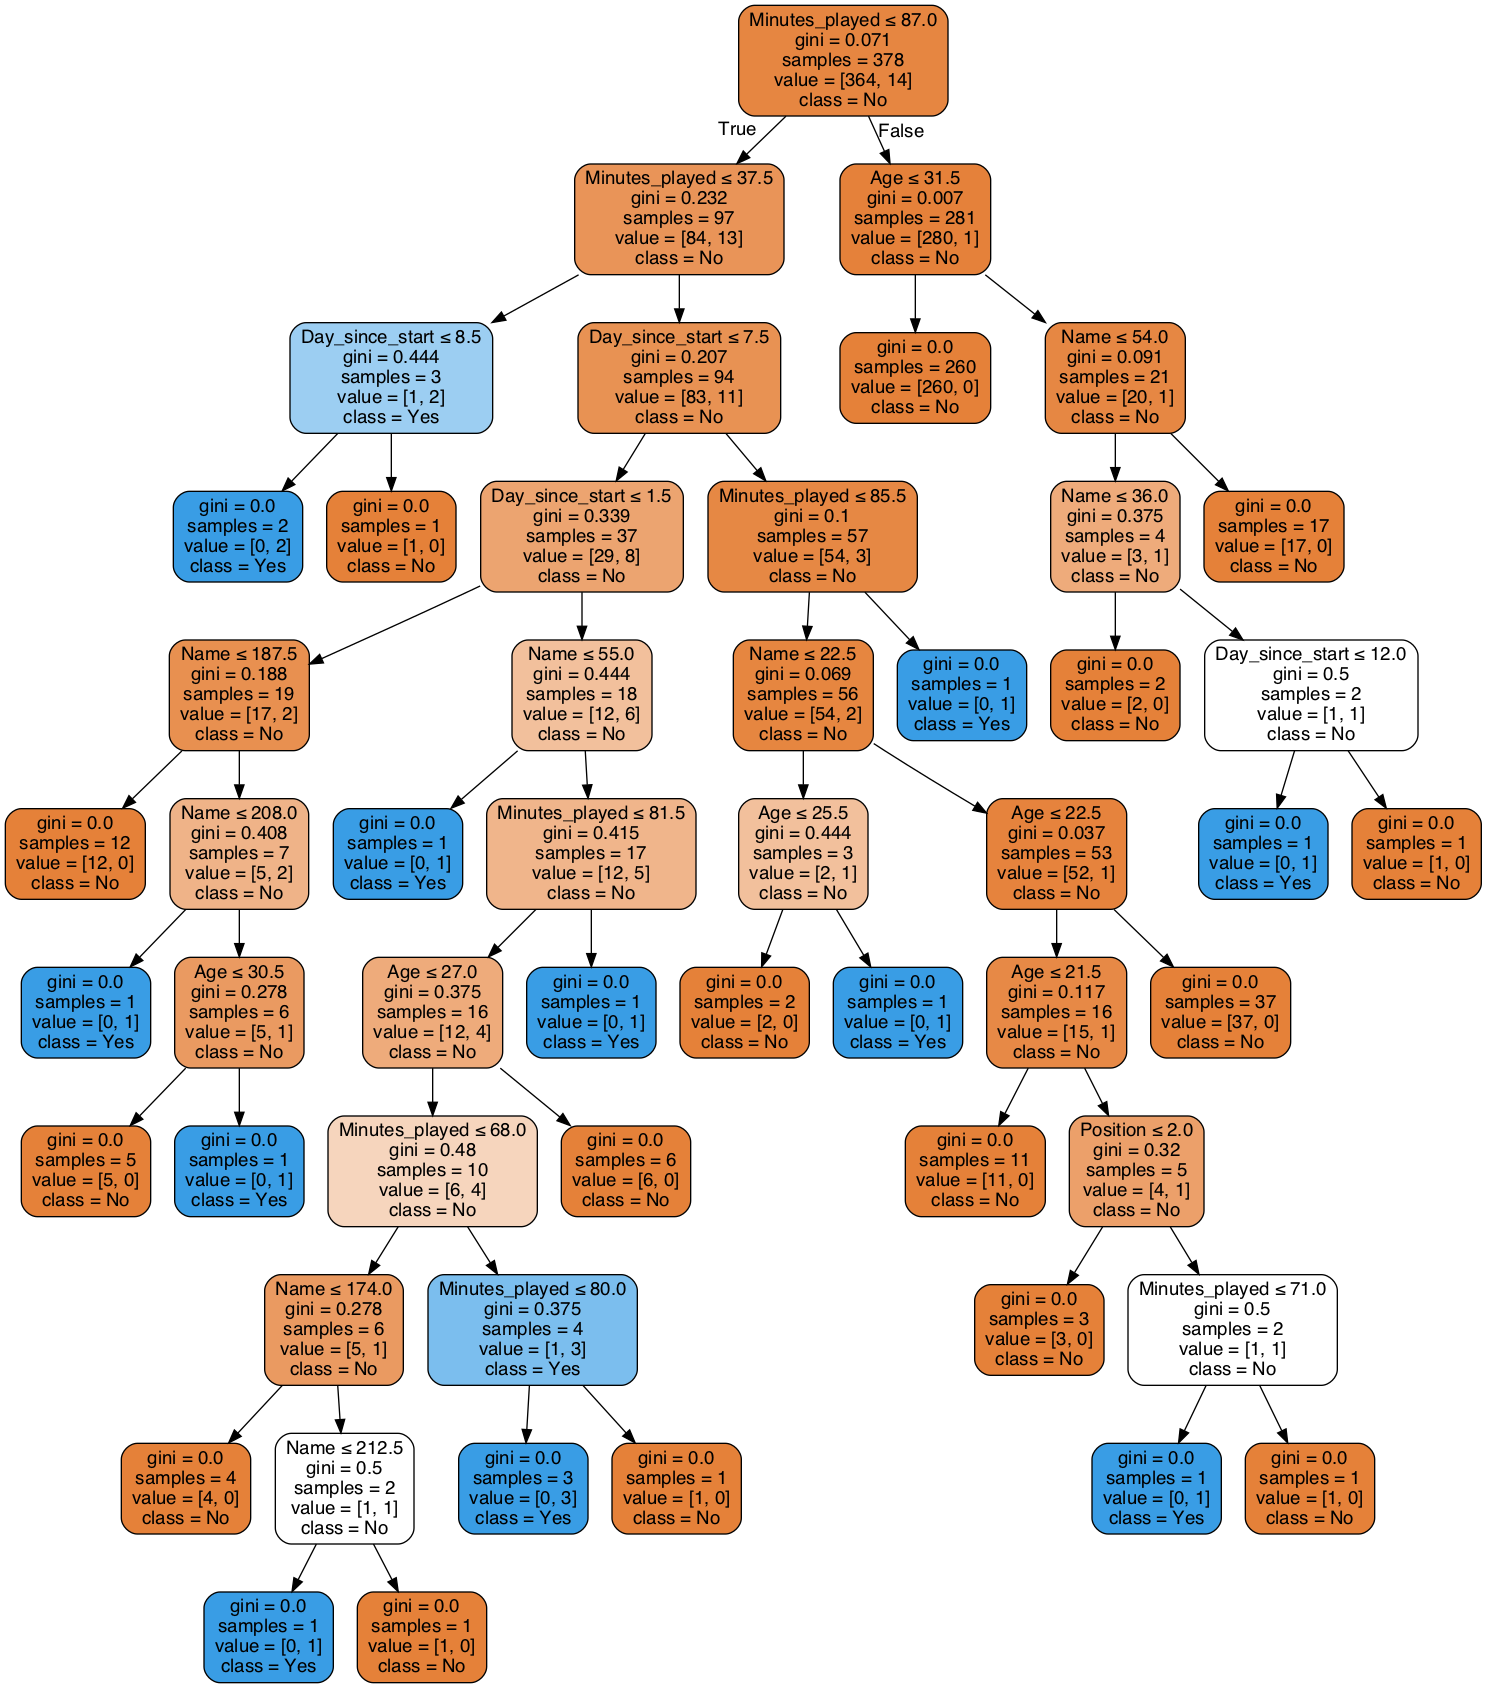

In [55]:
feature_cols = ['Name', 'Position', 'Minutes_played', 'Day_since_start', 'Age'] 

dot_data = StringIO()
export_graphviz(classifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols, class_names=['No','Yes'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('predictions.png')
Image(graph.create_png())

In [56]:
# start_date = "2018-08-10"
# end_date = "2018-08-10"

# ids = soccer.fixtures(start_date, end_date, includes=('lineup', 'substitutions', 'venue'))


# for f in ids:
#     current_date = f["time"]["starting_at"]["date"]   
#     id_player = f['lineup'][1]['player_id']
#     player = soccer.player(id_player)
#     birth_date = player['birthdate']
#     format_current = "%Y-%m-%d"
#     format_birth = "%d/%m/%Y"
#     a = datetime.strptime(birth_date, format_birth)
#     b = datetime.strptime(current_date, format_current)
#     delta = b - a
#     years = delta.days / 365.25
#     print(int(years))
        
        
        